# Example of data translation using a bijective graph
The graph method creates a series of interlocking nodes that have transformations between themselves. There are a few basic rules:
1. Any node has an edge into and out of itself
2. Any path that results in the same end location creates the same node 

## This example is one of a rectangular table, a set of column modeled data. 
### This graph has the folowing nodes, and hence transformations between all of them
1. n1, 'Pandas Data Frame', in memory 
2. n2, 'AsciiDataTable', in memory
3. n3, 'HDF File', on disk
4. n4, 'XML Data Table',in memory
5. n5, 'Excel File', on disk
6. n6, 'HTML String',in memory
7. n7, 'JSON File', on disk
8. n8, 'JSON String',in memory
9. n9,'CSV File', on disk
10. n10, 'Matlab File', on disk

In [136]:
from pyMeasure import *
import pandas
from scipy.io import savemat,loadmat
import re
import datetime
import numpy as np
from ipywidgets import *
import json
import networkx

In [358]:


def edge_1_to_2(in_string):
    return in_string.splitlines()
    
def edge_2_to_1(string_list):
    return string_list_collapse(string_list)

class Graph():
    def __init__(self,**options):
        """Initializes the graph. The first 2 nodes and two edges forming a bijection between them are required"""
        defaults={"graph_name":"Graph",
                  "node_names":['n1','n2'],
                  "node_descriptions":{'n1':"A plain string",
                                       'n2':"A list of strings with no \\n, created with string.splitlines()"},
                  "current_node":'n1',
                  "state":[1,0],
                  "data":"This is a test string\n it has to have multiple lines \n and many characters 34%6\n^",
                  "edge_2_to_1":edge_2_to_1,
                  "edge_1_to_2":edge_1_to_2
                 }
        self.options={}
        for key,value in defaults.iteritems():
            self.options[key]=value
        for key,value in options.iteritems():
            self.options[key]=value
        self.elements=['graph_name','node_names','node_descriptions','current_node','state','data']
        for element in self.elements:
            self.__dict__[element]=self.options[element]
        self.edges=[]
        self.edge_matrices=[]
        self.state_matrix=np.matrix(self.state).T
        # Add the first 2 edges, required to intialize the graph properly
        self.add_edge(self.node_names[0],self.node_names[1],self.options["edge_1_to_2"])
        self.add_edge(self.node_names[1],self.node_names[0],self.options["edge_2_to_1"])
        
    def set_state(self,node_name,node_data):
        """Sets the graph state to be the state specified by node_name, and node_data"""
        try:
            current_node_state_position=self.node_names.index(node_name)
            self.current_node=node_name
            self.data=node_data
            self.state=[0 for i in range(len(self.node_names))]
            self.state[current_node_state_position]=1
            self.state_matrix=np.matrix(self.state).T
        except:
            print("Could not set the state of graph: {0}".format(self.graph_name))
            raise
            
    def add_edge(self,begin_node=None,end_node=None,edge_function=None):
        """Adds an edge mapping one node to another, required input is begin_node (it's name)
        end_node, and the edge function"""
        # check to see if edge is defined if it is increment a number
        edge_match=re.compile("edge_{0}_{1}".format(begin_node,end_node))
        keys=self.__dict__.keys()
        #print keys
        iterator=0
        for key in keys:
            if re.match(edge_match,key):
                iterator+=1
        edge_name="edge_{0}_{1}_{2:0>3d}".format(begin_node,end_node,iterator)
        self.__dict__[edge_name]=edge_function
        self.edges.append(edge_name)
        edge_matrix=np.zeros((len(self.state),len(self.state)))
        begin_position=self.node_names.index(begin_node)
        end_position=self.node_names.index(end_node)
        edge_matrix[end_position][begin_position]=1
        edge_matrix=np.matrix(edge_matrix)
        self.edge_matrices.append(edge_matrix)
        
    def move_to(self,path):
        """Changes the state of the graph by moving along the path specified"""
        print path
        for index,edge in enumerate(path):
            #print edge
            edge_pattern='edge_(?P<begin_node>\w+)_(?P<end_node>\w+)_(?P<iterator>\w+)'
            match=re.match(edge_pattern,edge)
            begin_node=match.groupdict()['begin_node']
            end_node=match.groupdict()['end_node']
            print("moving {0} -> {1}".format(begin_node,end_node))
            #print self.data
            self.data=self.__dict__[edge](self.data)
            #print self.data
            self.current_node=match.groupdict()['end_node']
            self.state=[0 for i in range(len(self.node_names))]
            position=self.node_names.index(self.current_node)
            self.state[position]=1
            self.state_matrix=np.matrix(self.state).T
            #print self.state
            #print self.current_node
            
    def virtual_move_to(self,path):
        """virtual_move_to simulates moving but does not change the state of the graph"""
        #print path
        temp_state=self.state
        temp_data=self.data
        temp_current_node=self.current_node
        temp_node_names=self.node_names
        for index,edge in enumerate(path):
            #print edge
            edge_pattern='edge_(?P<begin_node>\w+)_(?P<end_node>\w+)_(?P<iterator>\w+)'
            match=re.match(edge_pattern,edge)
            begin_node=match.groupdict()['begin_node']
            end_node=match.groupdict()['end_node']
            #print("moving {0} -> {1}".format(begin_node,end_node))
            #print self.data
            temp_data=self.__dict__[edge](temp_data)
            #print self.data
            temp_current_node=match.groupdict()['end_node']
            temp_state=[0 for i in range(len(temp_node_names))]
            position=temp_node_names.index(temp_current_node)
            temp_state[position]=1
            #print temp_state
            #print self.state
            #print self.current_node  
            
    def __str__(self):
        return str(self.data)
    
    def add_node(self,node_name,edge_into_node_begin,edge_into_node_function,edge_out_node_end,
                 edge_out_node_function):
        """Adds a node to the graph. Required input is node_name (a string with no spaces), 
        a reference to an entering node,the function mapping the entering node to the new node, 
        a reference to an exiting node and the function mapping the
        new node to the exiting node."""
        # first check if node into and out of node is good
        self.node_names.append(node_name)
        self.state.append(0)
        self.state_matrix=np.matrix(self.state).T
        for index,matrix in enumerate(self.edge_matrices):
            pad_row=np.zeros((1,len(matrix)))
            new_matrix=np.concatenate((matrix, pad_row), axis=0)
            pad_column=np.zeros((1,len(self.node_names)))
            new_matrix=np.concatenate((new_matrix, pad_column.T), axis=1)
            #print("New matrix is :\n{0}".format(new_matrix))
            self.edge_matrices[index]=new_matrix
        self.add_edge(begin_node=node_name,end_node=edge_out_node_end,edge_function=edge_out_node_function)
        self.add_edge(begin_node=edge_into_node_begin,end_node=node_name,edge_function=edge_into_node_function)
    
    def path_length(self,path,num_repeats=10):
        """Determines the length of a given path, currently the metric is based on the time to move to."""
        begin_time=datetime.datetime.now()
        #num_repeats=100
        for i in range(num_repeats):
            self.virtual_move_to(path)
        end_time=datetime.datetime.now()
        delta_t=end_time-begin_time
        path_length=delta_t.total_seconds()/float(num_repeats)
        if path_length ==0.0:
            print("Warning the path length is less than 1 microsecond," 
                  "make sure num_repeats is high enough to measure it.")
        return path_length
                
    def is_path_valid(self,path):
        """Returns True if the path is valid from the current node position or False otherwise"""
        null_state=[0 for i in range(len(self.node_names))]
        null_state_matrix=np.matrix(null_state).T
        new_state=np.matrix(self.state).T
        for index,edge in enumerate(path):
            #print index
            #print edge
            edge_position=self.edges.index(edge)
            move_matrix=self.edge_matrices[edge_position]
            #print move_matrix
            new_state=move_matrix*new_state
            if new_state.any()==null_state_matrix.any():
                #print new_state
                #print null_state_matrix
                return False
        return True
            
            
    def get_entering_nodes(self,node): 
        """Returns all nodes that have an edge that enter the specificed node"""
        enter_edge_pattern=re.compile('edge_(?P<begin_node>\w+)_{0}_(?P<iterator>\w+)'.format(node))
        enter_nodes=[]
        for index,edge in enumerate(self.edges):
            enter_match=re.match(enter_edge_pattern,edge)
            if enter_match:
                enter_node=enter_match.groupdict()['begin_node']
                enter_nodes.append(enter_node)
        return enter_nodes
    
    def get_entering_edges(self,node): 
        """Returns all edges that enter the specificed node"""
        enter_edge_pattern=re.compile('edge_(?P<begin_node>\w+)_{0}_(?P<iterator>\w+)'.format(node))
        enter_edges=[]
        for index,edge in enumerate(self.edges):
            if re.match(enter_edge_pattern,edge):
                enter_edges.append(edge)
        return enter_edges
    
    def get_exiting_edges(self,node):
        """Returns all edges that exit the specificed node"""
        exit_edge_pattern=re.compile('edge_{0}_(?P<end_node>\w+)_(?P<iterator>\w+)'.format(node))
        exit_edges=[]
        for index,edge in enumerate(self.edges):
            if re.match(exit_edge_pattern,edge):
                exit_edges.append(edge)
        return exit_edges 
    
    def get_exiting_nodes(self,node): 
        """Returns all nodes that have an edge leaving the specificed node"""
        exit_edge_pattern=re.compile('edge_{0}_(?P<end_node>\w+)_(?P<iterator>\w+)'.format(node))
        exit_nodes=[]
        for index,edge in enumerate(self.edges):
            exit_match=re.match(exit_edge_pattern,edge)
            if exit_match:
                exit_node=exit_match.groupdict()['end_node']
                exit_nodes.append(exit_node)
        return exit_nodes
    
    def get_path(self,first_node,last_node):
        """Returns the first path found between first node and last node, three step paths are broken"""
        edge_pattern=re.compile('edge_(?P<begin_node>\w+)_(?P<end_node>\w+)_(?P<iterator>\w+)')
        exit_paths=self.get_exiting_edges(first_node)
        next_nodes=self.get_exiting_nodes(first_node)
        #be careful here using the wrong assignment statement breaks this function 
        possible_paths=[]
        for exit_path in exit_paths:
            possible_paths.append([exit_path])
        #print("{0} is {1}".format('possible_paths',possible_paths))
        for i in range(len(self.node_names)):
            for index,path in enumerate(possible_paths):
                last_edge=path[-1]
                match=re.match(edge_pattern,last_edge)
                begin_node=match.groupdict()['begin_node']
                end_node=match.groupdict()['end_node']
                #print next_node
                if end_node==last_node:
                    #print("The path found is {0}".format(path))
                    return path
                next_possible_paths=[]
                next_edges=self.get_exiting_edges(end_node)
                next_nodes=self.get_exiting_nodes(end_node)
                #print("{0} is {1}".format('next_edges',next_edges))
                for index,next_edge in enumerate(next_edges):
                    #be careful here using the wrong assignment statement breaks this function 
                    #next_path=path is a deal breaker!! 
                    
                    # This keeps it from getting stuck on circular paths
                    if next_edge in path:
                        continue
                    next_path=[]
                    for edge in path:
                        next_path.append(edge)
                    #print("{0} is {1}".format('next_path',next_path))
                    #print("{0} is {1}".format('next_edge',next_edge))
                    #next_node=next_nodes[index]
                    #print next_node
                    next_match=re.match(edge_pattern,next_edge)
                    next_node=next_match.groupdict()["end_node"]
                    begin_node_next_edge=next_match.groupdict()["begin_node"]
                    #print("{0} is {1}".format('next_node',next_node))
                    #print("{0} is {1}".format('begin_node_next_edge',begin_node_next_edge))
                    
                    if next_node==last_node and begin_node_next_edge==end_node:
                        next_path.append(next_edge)
                        #print("The path found is {0}".format(next_path))
                        return next_path
                    elif begin_node_next_edge==end_node:
                        next_path.append(next_edge)
                        next_possible_paths.append(next_path)
                        
                        #print("{0} is {1}".format('next_possible_paths',next_possible_paths))
                    else:
                        print("Path is not found")
                        pass

                    #print("{0} is {1}".format('next_possible_paths',next_possible_paths))
                possible_paths=next_possible_paths
                #print("{0} is {1}".format('possible_paths',possible_paths))
    
    def move_to_node(self,node):
        """Moves from current_node to the specified node"""
        path=self.get_path(self.current_node,node)
        self.move_to(path)
            
    def check_closed_path(self):
        """Checks that data is not changed for the first closed path found. Returns True if data==data after
        moving around the closed path, False otherwise. Starting point is current_node """
        temp_data=self.data
        path=self.get_path(self.current_node,self.current_node)
        if self.is_path_valid(path):
            pass
        else:
            print("Path is not valid, graph definition is broken")
            raise
        out=temp_data==self.data
        out_list=[self.current_node,path,out]
        print("The assertion that the data remains unchanged,\n" 
              "for node {0} following path {1} is {2}".format(*out_list))
        return out 
    
    def is_graph_isomorphic(self):
        """Returns True if all nodes have closed paths that preserve the data, False otherwise"""
        out=True
        for node in self.node_names:
            self.move_to_node(node)
            if not self.check_closed_path:
                out=False
        return out
    
    def show(self,**options):
        """Shows the graph using matplotlib and networkx"""
        defaults={"descriptions":False,"save_figure":False,"path":None,"active_node":True}
        show_options={}
        for key,value in defaults.iteritems():
            show_options[key]=value
        for key,value in options.iteritems():
            show_options[key]=value
        new_graph=networkx.DiGraph()
        edge_pattern=re.compile("edge_(?P<begin_node>\w+)_(?P<end_node>\w+)_(?P<iterator>\w+)")
        for node in self.node_names:
            new_graph.add_node(node)
        for edge in self.edges:
            match=re.match(edge_pattern,edge)
            if match:
                begin_node=match.groupdict()["begin_node"]
                end_node=match.groupdict()["end_node"]
                new_graph.add_edge(begin_node,end_node)
                #print("Begin Node = {0}, End Node= {1}".format(begin_node,end_node))

        if show_options["active_node"]:
            node_colors=[]
            for node in self.state:
                if node==1:
                    node_colors.append('b')
                else:
                    node_colors.append('r')
        else:
            node_colors=['r' for node in self.node_names]
        if show_options["descriptions"]:
            networkx.draw_networkx(new_graph,arrows=True,
                       labels={node:rect_graph.node_descriptions[index] for index, 
                               node in enumerate(rect_graph.node_names)},node_color=node_colors,
                                   node_size=1500,font_size=10)
        else:
            networkx.draw_networkx(new_graph,arrows=True,node_color=node_colors)
            
        plt.suptitle(self.options["graph_name"])
        plt.show()
            


In [359]:
options={}
options["data"]=[[1,2,3],[4,5,6]]
options["column_names"]=['a','b','c']
table=AsciiDataTable(None,**options)
table=OnePortCalrepModel(os.path.join(TESTS_DIRECTORY,'700437.asc'))
table=SNP(os.path.join(TESTS_DIRECTORY,'Solution_0.s4p'))
data_frame=AsciiDataTable_to_DataFrame(table)

The self.metadata["Device_Id"] variable is 700437


In [360]:
graph_options={"graph_name":"Rectangular Graph",
                  "node_names":['n1','n2'],
                  "node_descriptions":["Pandas Data Frame","AsciiDataTable"],
                  "current_node":'n1',
                  "state":[1,0],
                  "data":data_frame,
                  "edge_2_to_1":AsciiDataTable_to_DataFrame,
                  "edge_1_to_2":DataFrame_to_AsciiDataTable
                 }
rect_graph=Graph(**graph_options)

<IPython.core.display.Javascript object>


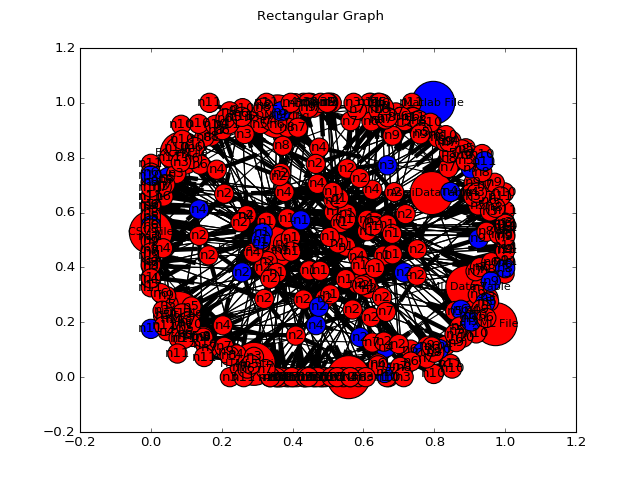

In [363]:
rect_graph.show(descriptions=True)

In [315]:
rect_graph.is_graph_isomorphic()

['edge_n1_n2_000', 'edge_n2_n1_000']
moving n1 -> n2
moving n2 -> n1
['edge_n1_n2_000']
moving n1 -> n2


True

In [316]:
rect_graph.move_to_node("n2")

['edge_n2_n1_000', 'edge_n1_n2_000']
moving n2 -> n1
moving n1 -> n2


In [7]:
#print rect_graph.data

In [362]:
# need to rename these Model1_to_Model2
def edge_1_to_3(pandas_data_frame):
    pandas_data_frame.to_hdf("Test.hdf","table")
    return "Test.hdf"
def edge_3_to_1(hdf_file_name):
    df=pandas.read_hdf(hdf_file_name,"table")
    return df

rect_graph.add_node("n3","n1",edge_1_to_3,"n1",edge_3_to_1)
rect_graph.node_descriptions.append("HDF File")

def edge_4_to_2(xml_table):
    
    table=AsciiDataTable(None,
                         column_names=xml_table.attribute_names,
                         data=xml_table.data)
    return table

def edge_2_to_4(data_table):
    xml=AsciiDataTable_to_XMLDataTable(data_table)
    return xml

rect_graph.add_node("n4","n2",edge_2_to_4,"n2",edge_4_to_2)
rect_graph.node_descriptions.append("XML Data Table")

# Need to add XML File and Html File using save and save_HTML()


def edge_1_to_5(pandas_data_frame,file_name="Test.xlsx"):
    pandas_data_frame.to_excel(file_name,index=False)
    return file_name

def edge_5_to_1(excel_file_name):
    df=pandas.read_excel(excel_file_name)
    return df

rect_graph.add_node("n5","n1",edge_1_to_5,"n1",edge_5_to_1)
rect_graph.node_descriptions.append("Excel File")

def edge_1_to_6(pandas_data_frame):
    html=pandas_data_frame.to_html(index=False)
    return html

def edge_6_to_1(html_string):
    list_df=pandas.read_html(html_string)
    return list_df[0]

rect_graph.add_node("n6","n1",edge_1_to_6,"n1",edge_6_to_1)
rect_graph.node_descriptions.append("HTML String")

# Note a lot of the pandas reading and writing cause float64 round off errors
# applymap(lambda x: np.around(x,10) any all float fields will fix this
# also the column names move about in order

def edge_1_to_7(pandas_data_frame):
    json=pandas_data_frame.to_json("test.json",orient='records')
    return "test.json"

def edge_7_to_1(json_file_name):
    data_frame=pandas.read_json(json_file_name,orient='records')
    return data_frame

rect_graph.add_node("n7","n1",edge_1_to_7,"n1",edge_7_to_1)
rect_graph.node_descriptions.append("JSON File")

def edge_1_to_8(pandas_data_frame):
    json=pandas_data_frame.to_json(orient='records')
    return json

def edge_8_to_1(json_string):
    data_frame=pandas.read_json(json_string,orient='records')
    return data_frame

rect_graph.add_node("n8","n1",edge_1_to_8,"n1",edge_8_to_1)
rect_graph.node_descriptions.append("JSON String")

def edge_1_to_9(pandas_data_frame,file_name="test.csv"):
    json=pandas_data_frame.to_csv(file_name,index=False)
    return file_name

def edge_9_to_1(csv_file_name):
    data_frame=pandas.read_csv(csv_file_name)
    return data_frame

rect_graph.add_node("n9","n1",edge_1_to_9,"n1",edge_9_to_1)
rect_graph.node_descriptions.append("CSV File")

def edge_2_to_10(ascii_data_table,file_name="test.mat"):
    matlab_data_dictionary={"data":ascii_data_table.data,"column_names":ascii_data_table.column_names}
    savemat(file_name,matlab_data_dictionary)
    return file_name

def edge_10_to_2(matlab_file_name):
    matlab_data_dictionary=loadmat(matlab_file_name)
    ascii_data_table=AsciiDataTable(None,
                                    column_names=map(lambda x: x.rstrip().lstrip(),
                                                     matlab_data_dictionary["column_names"].tolist()),
                                     data=matlab_data_dictionary["data"].tolist())
    return ascii_data_table

rect_graph.add_node("n10","n2",edge_2_to_10,"n2",edge_10_to_2)
rect_graph.node_descriptions.append("Matlab File")

# def edge_4_to_11(xml_data_table):
#     return xml_data_table

# def edge_11_to_4(xml_data_table):
#     return xml_data_table

# rect_graph.add_node("n11","n4",edge_4_to_11,"n4",edge_11_to_4)
# rect_graph.node_descriptions.append("XML File")


def edge_4_to_11(xml_data_table,file_name="test.xml"):
    xml_data_table.save(file_name)
    return file_name

def edge_11_to_4(xml_file_name):
    xml_data_table=DataTable(xml_file_name)
    return xml_data_table

rect_graph.add_node("n11","n4",edge_4_to_11,"n4",edge_11_to_4)
rect_graph.node_descriptions.append("XML File")

def edge_7_to_4(json_file_string):
    data_dictionary_list=json.load(open(json_file_string,'r'))
    xml=DataTable(None,data_dictionary={"data":data_dictionary_list})
    return xml
rect_graph.add_edge("n7","n4",edge_7_to_4)

In [326]:
rect_graph.edges

['edge_n1_n2_000',
 'edge_n2_n1_000',
 'edge_n3_n1_000',
 'edge_n1_n3_000',
 'edge_n4_n2_000',
 'edge_n2_n4_000',
 'edge_n5_n1_000',
 'edge_n1_n5_000',
 'edge_n6_n1_000',
 'edge_n1_n6_000',
 'edge_n7_n1_000',
 'edge_n1_n7_000',
 'edge_n8_n1_000',
 'edge_n1_n8_000',
 'edge_n9_n1_000',
 'edge_n1_n9_000',
 'edge_n10_n2_000',
 'edge_n2_n10_000',
 'edge_n11_n4_000',
 'edge_n4_n11_000',
 'edge_n7_n4_000']

In [327]:
rect_graph.is_graph_isomorphic()

['edge_n1_n2_000', 'edge_n2_n1_000']
moving n1 -> n2
moving n2 -> n1
['edge_n1_n2_000']
moving n1 -> n2
['edge_n2_n1_000', 'edge_n1_n3_000']
moving n2 -> n1
moving n1 -> n3
['edge_n3_n1_000', 'edge_n1_n2_000', 'edge_n2_n4_000']
moving n3 -> n1
moving n1 -> n2
moving n2 -> n4
['edge_n4_n11_000', 'edge_n11_n4_000', 'edge_n4_n2_000', 'edge_n2_n1_000', 'edge_n1_n5_000']
moving n4 -> n11
moving n11 -> n4
moving n4 -> n2
moving n2 -> n1
moving n1 -> n5
['edge_n5_n1_000', 'edge_n1_n6_000']
moving n5 -> n1
moving n1 -> n6
['edge_n6_n1_000', 'edge_n1_n7_000']
moving n6 -> n1
moving n1 -> n7
['edge_n7_n1_000', 'edge_n1_n8_000']
moving n7 -> n1
moving n1 -> n8
['edge_n8_n1_000', 'edge_n1_n9_000']
moving n8 -> n1
moving n1 -> n9
['edge_n9_n1_000', 'edge_n1_n2_000', 'edge_n2_n10_000']
moving n9 -> n1
moving n1 -> n2
moving n2 -> n10
['edge_n10_n2_000', 'edge_n2_n4_000', 'edge_n4_n11_000']
moving n10 -> n2
moving n2 -> n4
moving n4 -> n11


True

In [70]:
#print rect_graph.data

In [320]:
path=rect_graph.get_path("n4","n5")

next_possible_paths is [['edge_n4_n2_000', 'edge_n2_n1_000']]
next_possible_paths is [['edge_n4_n2_000', 'edge_n2_n1_000'], ['edge_n4_n2_000', 'edge_n2_n4_000']]
next_possible_paths is [['edge_n4_n2_000', 'edge_n2_n1_000'], ['edge_n4_n2_000', 'edge_n2_n4_000'], ['edge_n4_n2_000', 'edge_n2_n10_000']]
next_possible_paths is [['edge_n4_n11_000', 'edge_n11_n4_000']]
next_possible_paths is [['edge_n4_n11_000', 'edge_n11_n4_000', 'edge_n4_n2_000']]
next_possible_paths is [['edge_n4_n11_000', 'edge_n11_n4_000', 'edge_n4_n2_000', 'edge_n2_n1_000']]
next_possible_paths is [['edge_n4_n11_000', 'edge_n11_n4_000', 'edge_n4_n2_000', 'edge_n2_n1_000'], ['edge_n4_n11_000', 'edge_n11_n4_000', 'edge_n4_n2_000', 'edge_n2_n4_000']]
next_possible_paths is [['edge_n4_n11_000', 'edge_n11_n4_000', 'edge_n4_n2_000', 'edge_n2_n1_000'], ['edge_n4_n11_000', 'edge_n11_n4_000', 'edge_n4_n2_000', 'edge_n2_n4_000'], ['edge_n4_n11_000', 'edge_n11_n4_000', 'edge_n4_n2_000', 'edge_n2_n10_000']]
next_possible_paths is [

In [321]:
path

['edge_n4_n11_000',
 'edge_n11_n4_000',
 'edge_n4_n2_000',
 'edge_n2_n1_000',
 'edge_n1_n5_000']

In [258]:
rect_graph.move_to(path)

['edge_n4_n2_000', 'edge_n2_n1_000', 'edge_n1_n5_000']
moving n4 -> n2
moving n2 -> n1
moving n1 -> n5


In [174]:
rect_graph.move_to_node("n11")

moving n4 -> n11


In [ ]:
xml=AsciiDataTable_to_XMLDataTable(table)

In [ ]:
xml.to_tuple_list(xml.get_attribute_names())

In [ ]:
xml.to_list("a")

In [ ]:
xml.attribute_names

In [ ]:
xml.data

In [ ]:
rect_graph.state

In [ ]:
path=rect_graph.get_path("n5","n1")

In [ ]:
rect_graph.path_length(path)

In [ ]:
rect_graph.move_to_node("n1")

In [331]:
rect_graph.move_to_node("n1")
for node in rect_graph.node_names:
    path=rect_graph.get_path("n1",node)
    print("The length of the path n1-> {0} in s is {1}".format(node,rect_graph.path_length(path)))

['edge_n1_n2_000', 'edge_n2_n1_000']
moving n1 -> n2
moving n2 -> n1
The length of the path n1-> n1 in s is 0.0168
The length of the path n1-> n2 in s is 0.0124
The length of the path n1-> n3 in s is 0.0135
The length of the path n1-> n4 in s is 0.0622
The length of the path n1-> n5 in s is 0.164
The length of the path n1-> n6 in s is 0.1233
The length of the path n1-> n7 in s is 0.0053
The length of the path n1-> n8 in s is 0.0006
The length of the path n1-> n9 in s is 0.0054
The length of the path n1-> n10 in s is 0.016
The length of the path n1-> n11 in s is 0.0926


In [ ]:
rect_graph.state

In [ ]:
rect_graph.move_to_node("n1")

In [ ]:
html=rect_graph.data.to_html(index=False)

In [ ]:
df=pandas.read_html(html)

In [ ]:
rect_graph.edges

In [ ]:
table=OnePortCalrepModel(os.path.join(TESTS_DIRECTORY,'700437.asc'))
rect_graph.set_state("n2",table)

In [329]:
rect_graph.move_to_node("n1")

['edge_n11_n4_000', 'edge_n4_n2_000', 'edge_n2_n1_000']
moving n11 -> n4
moving n4 -> n2
moving n2 -> n1


In [ ]:
print rect_graph.data

In [ ]:
from ipywidgets import *


['edge_n6_n1_000', 'edge_n1_n7_000']
moving n6 -> n1
moving n1 -> n7


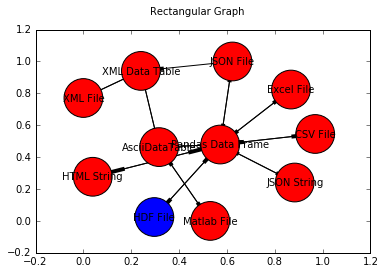

In [366]:
%matplotlib inline
def move_and_show(end_node_number):
    node=rect_graph.node_names[end_node_number]
    rect_graph.move_to_node(node)
    rect_graph.show(descriptions=True)
    
interact(move_and_show,end_node_number=(0,len(rect_graph.node_names)-1,1))

In [330]:
def move_and_print(end_node_number):
    node=rect_graph.node_names[end_node_number]
    rect_graph.move_to_node(node)
    print("*"*80)
    print("{0}".format(rect_graph.node_descriptions[end_node_number])+" {0}".format(rect_graph.state))
    print("*"*80)
    print rect_graph.data
    
interact(move_and_print,end_node_number=(0,len(rect_graph.node_names)-1,1))

['edge_n5_n1_000', 'edge_n1_n6_000']
moving n5 -> n1
moving n1 -> n6
********************************************************************************
HTML String [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
********************************************************************************
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>Frequency</th>
      <th>imS11</th>
      <th>imS12</th>
      <th>imS13</th>
      <th>imS14</th>
      <th>imS21</th>
      <th>imS22</th>
      <th>imS23</th>
      <th>imS24</th>
      <th>imS31</th>
      <th>imS32</th>
      <th>imS33</th>
      <th>imS34</th>
      <th>imS41</th>
      <th>imS42</th>
      <th>imS43</th>
      <th>imS44</th>
      <th>reS11</th>
      <th>reS12</th>
      <th>reS13</th>
      <th>reS14</th>
      <th>reS21</th>
      <th>reS22</th>
      <th>reS23</th>
      <th>reS24</th>
      <th>reS31</th>
      <th>reS32</th>
      <th>reS33</th>
      <th>reS34</th>
      <th>reS41</th>
      

In [ ]:
json=data_frame.to_json("test.json",orient='records')

In [ ]:
json_string=data_frame.to_json(orient='records')

In [ ]:
new_df=pandas.read_json(json_string,orient='records')

In [ ]:
new_df=pandas.read_json("test.json",orient='records')

In [ ]:
#str(table.get_data_dictionary_list())
json

In [ ]:
rect_graph.node_descriptions


In [ ]:
import json
test_list=json.load(open("test.json",'r'))

In [ ]:
text_xml=DataTable(None,**{"data_dictionary":{"data":test_list}})

In [ ]:
#print text_xml

In [ ]:
rect_graph.edges

In [ ]:
rect_graph.move_to_node("n7")

In [ ]:
rect_graph.move_to_node("n4")

In [ ]:
#print rect_graph.data

In [ ]:
from scipy.io import savemat,loadmat

In [ ]:
savemat("data.mat",{"data":table.data,"column_names":table.column_names})

In [ ]:
data=loadmat("data.mat")

In [ ]:
new_table=AsciiDataTable(None,column_names=map(lambda x: x.rstrip().lstrip(),data["column_names"].tolist()),
                         data=data["data"].tolist())

In [ ]:
rect_graph.move_to_node("n4")
xml=rect_graph.data

In [ ]:
import sqlite3
import odo

In [ ]:
data_frame.dtypes[0]

In [ ]:
conn = sqlite3.connect("test.db")
conn.execute("create table data")
odo.odo(data_frame,'sqlite:///test.db::data')

In [15]:
one_port=OnePortCalrepModel(os.path.join(TESTS_DIRECTORY,'700437.asc'))

The self.metadata["Device_Id"] variable is 700437


In [ ]:
one_port.header

In [ ]:
one_port.column_names

In [18]:
one_port.metadata

{'Analysis_Date': '16-Oct-15', 'Device_Id': '700437'}

In [19]:
for element in one_port.elements:
    print element

header
column_names
data
footer
inline_comments
metadata


In [ ]:
header_table=pandas.DataFrame(one_port.header,columns=["Header_Line_Content"])
data_table=pandas.DataFrame(one_port.data,columns=one_port.column_names)
footer_table=pandas.DataFrame(one_port.footer,columns=["Footer_Line_Content"])
inline_comments=pandas.DataFrame(one_port.footer,columns=["Line","Location","Comment"])
metadata_table=pandas.DataFrame([[key,value] for key,value in one_port.metadata.iteritems() ], 
                                columns=["Property","Value"])

In [ ]:
header_table

In [129]:
# Move this to a DataTable Graph Example
def AsciiDataTable_to_DataFrame_dict(AsciiDataTable):
    """Converts an AsciiDataTable to a dictionary of pandas.DataFrame s"""
    output_dict={}
    for element in AsciiDataTable.elements:
        #print("{0} is {1}".format('element',element))
        if AsciiDataTable.__dict__[element]:
            if re.search('header',element,re.IGNORECASE):
                header_table=pandas.DataFrame(AsciiDataTable.header,columns=["Header_Line_Content"])
                output_dict["Header"]=header_table
            # needs to be before data search    
            elif re.search('meta',element,re.IGNORECASE):
                #print("{0} is {1}".format('element',element))
                metadata_table=pandas.DataFrame([[key,value] for key,value in AsciiDataTable.metadata.iteritems()], 
                                columns=["Property","Value"])
                output_dict["Metadata"]=metadata_table    
            elif re.search('data|^meta',element,re.IGNORECASE):
                
                data_table=pandas.DataFrame(AsciiDataTable.data,columns=AsciiDataTable.column_names)
                output_dict["Data"]=data_table
                
            elif re.search('footer',element,re.IGNORECASE):
                footer_table=pandas.DataFrame(AsciiDataTable.footer,columns=["Footer_Line_Content"])
                output_dict["Footer"]=footer_table
                
            elif re.search('comment',element,re.IGNORECASE):
                comments=AsciiDataTable.__dict__[element]
                inline_comments=pandas.DataFrame(comments,columns=["Comment","Line","Location"])
                output_dict["Comments"]=inline_comments
                

    return output_dict

def DataFrame_dict_to_AsciiDataTable(DataFrame_dict,**options):
    """Given a dictionary of pandas DataFrames returns an AsciiDataTable"""
    defaults={"inline_comment_begin":"!","inline_comment_end":"\n"}
    table_options={}
    for key,value in defaults.iteritems():
        table_options[key]=value
    for key,value in options.iteritems():
        table_options[key]=value
    keys=DataFrame_dict.keys()
    for key in keys:
        table_key=key
        if key in["comments","Comments","inline_comments","Inline_Comments"]:
            table_key="inline_comments"
        if key in ["data","Data"]:
            table_options["column_names"]=DataFrame_dict[key].columns.tolist()
            
        table_options[table_key.lower()]=DataFrame_dict[key].as_matrix().tolist()
    new_table=AsciiDataTable(None,**table_options)
    return new_table
        
    

In [43]:
panda_dict=AsciiDataTable_to_DataFrame_dict(one_port)

In [44]:
panda_dict["Metadata"]

,Property,Value
0,Analysis_Date,16-Oct-15
1,Device_Id,700437


In [46]:
#panda_dict["Data"]

In [107]:
def DataFrame_dict_to_excel(DataFrame_dict,excel_file_name="Test.xlsx"):
    """Converts a dictionary of pandas DataFrames to a single excel file with sheet names
    determined by keys"""
    # sort the keys so that they will display in the same order
    writer = pandas.ExcelWriter(excel_file_name)
    keys=sorted(DataFrame_dict.keys())
    for key in keys:
        #print key
        DataFrame_dict[key].to_excel(writer,sheet_name=key,index=False)
    writer.close()
    return excel_file_name

def excel_to_DataFrame_dict(excel_file_name):
    """Reads an excel file into a dictionary of data frames"""
    data_frame_dictionary=pandas.read_excel(excel_file_name,sheetname=None)
    return data_frame_dictionary
def DataFrame_dict_to_hdf(DataFrame_dict,hdf_file_name="Test.hd5"):
    """Transforms a dictionary of pandas.DataFrames to a single HD5 file with groups determined by the keys"""
    keys=sorted(DataFrame_dict.keys())
    for key in keys:
        DataFrame_dict[key].to_hdf(hdf_file_name,key)
    return hdf_file_name

def hdf_to_DataFrame_dict(hdf_file_name):
    """Creates a dictionary of pandas.DataFrames given a hd5 file name, does this require the table names?
    """
    hdf=h5py.File(hdf_file_name)
    keys=hdf.keys()
    pandas_dictionary={key:pandas.read_hdf(hdf_file_name,key) for key in keys}
    return pandas_dictionary
    

In [ ]:
DataFrame_dict_to_excel(panda_dict)

In [ ]:
test_dict=pandas.read_excel("Test.xlsx",sheetname=None)

In [ ]:
test_dict["Header"]

In [48]:
raw_table=TwoPortRawModel(os.path.join(TESTS_DIRECTORY,'TestFileTwoPortRaw.txt'))

In [49]:
test_dict=AsciiDataTable_to_DataFrame_dict(raw_table)

In [50]:
test_dict.keys()

['Header', 'Data', 'Metadata']

In [40]:
test_dict["Metadata"]

,Property,Value
0,Connector_Type_Calibration,
1,Number_Connects,3
2,Connector_Type_Measurement,N
3,Number_Repeats,1
4,Operator,BFR
5,Number_Frequencies,53
6,Start_Frequency,7
7,Measurement_Date,9 Sep 2015
8,Program_Used,MEASLP
9,Measurement_Type,2-port


In [41]:
test_dict["Header"]

,Header_Line_Content
0,HP8510
1,L
2,
3,N
4,2-port
5,9 Sep 2015
6,10:31:55
7,MEASLP
8,150122
9,BFR


In [53]:
excel=DataFrame_dict_to_excel(test_dict)

In [56]:
s2p=S2PV1(os.path.join(TESTS_DIRECTORY,'704b.S2P'))

In [67]:
test_dict=AsciiDataTable_to_DataFrame_dict(s2p)

In [60]:
s2p.comments

[['---------------------------------------------------------------------',
  0,
  0],
 [' ZVC, 3.52', 1, 0],
 ['---------------------------------------------------------------------',
  2,
  0],
 [' symbol freq-unit parameter-type data-format keyword impedance-ohm', 3, 0],
 ['---------------------------------------------------------------------',
  5,
  0],
 [' freq                dbS11          angS11          dbS21          angS21          dbS12          angS12          dbS22          angS22          ',
  6,
  0]]

In [68]:
excel=DataFrame_dict_to_excel(test_dict)

In [73]:
tet_dict=excel_to_DataFrame_dict("test.xlsx")

In [79]:
test_dict.keys()

['Data', 'Comments']

In [81]:
test_hd5=DataFrame_dict_to_hd5(test_dict)

In [100]:
import h5py
hdf=h5py.File("Test.hd5")
keys=hdf.keys()
pandas_dictionary={key:pandas.read_hdf("Test.hd5",key) for key in keys}

In [103]:
hdf.keys()

[u'Comments', u'Data']

In [108]:
pandas_dictionary=hdf_to_DataFrame_dict("Test.hd5")

In [109]:
pandas_dictionary.keys()

[u'Data', u'Comments']

In [112]:
pandas_dictionary["Comments"].as_matrix().tolist()

[['---------------------------------------------------------------------',
  0L,
  0L],
 [' ZVC, 3.52', 1L, 0L],
 ['---------------------------------------------------------------------',
  2L,
  0L],
 [' symbol freq-unit parameter-type data-format keyword impedance-ohm',
  3L,
  0L],
 ['---------------------------------------------------------------------',
  5L,
  0L],
 [' freq                dbS11          angS11          dbS21          angS21          dbS12          angS12          dbS22          angS22          ',
  6L,
  0L]]

In [130]:
table=DataFrame_dict_to_AsciiDataTable(pandas_dictionary)

In [134]:
#print table.get_data_string()

In [138]:
rect_graph.node_names

['n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9', 'n10']

In [139]:
new_graph=networkx.DiGraph()

In [333]:
for node in rect_graph.node_names:
    new_graph.add_node(node)

In [141]:
rect_graph.edges

['edge_n1_n2_000',
 'edge_n2_n1_000',
 'edge_n3_n1_000',
 'edge_n1_n3_000',
 'edge_n4_n2_000',
 'edge_n2_n4_000',
 'edge_n5_n1_000',
 'edge_n1_n5_000',
 'edge_n6_n1_000',
 'edge_n1_n6_000',
 'edge_n7_n1_000',
 'edge_n1_n7_000',
 'edge_n8_n1_000',
 'edge_n1_n8_000',
 'edge_n9_n1_000',
 'edge_n1_n9_000',
 'edge_n10_n2_000',
 'edge_n2_n10_000',
 'edge_n7_n4_000']

In [143]:
edge_pattern=re.compile("edge_(?P<begin_node>\w+)_(?P<end_node>\w+)_(?P<iterator>\w+)")

In [332]:
for edge in rect_graph.edges:
    match=re.match(edge_pattern,edge)
    if match:
        begin_node=match.groupdict()["begin_node"]
        end_node=match.groupdict()["end_node"]
        new_graph.add_edge(begin_node,end_node)
        print("Begin Node = {0}, End Node= {1}".format(begin_node,end_node))

Begin Node = n1, End Node= n2
Begin Node = n2, End Node= n1
Begin Node = n3, End Node= n1
Begin Node = n1, End Node= n3
Begin Node = n4, End Node= n2
Begin Node = n2, End Node= n4
Begin Node = n5, End Node= n1
Begin Node = n1, End Node= n5
Begin Node = n6, End Node= n1
Begin Node = n1, End Node= n6
Begin Node = n7, End Node= n1
Begin Node = n1, End Node= n7
Begin Node = n8, End Node= n1
Begin Node = n1, End Node= n8
Begin Node = n9, End Node= n1
Begin Node = n1, End Node= n9
Begin Node = n10, End Node= n2
Begin Node = n2, End Node= n10
Begin Node = n11, End Node= n4
Begin Node = n4, End Node= n11
Begin Node = n7, End Node= n4


In [150]:
networkx.draw_networkx(new_graph,arrows=True)
plt.show()

<IPython.core.display.Javascript object>


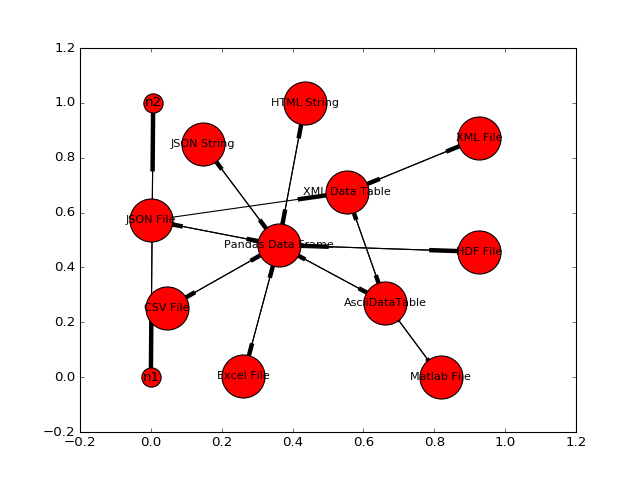

In [334]:
%matplotlib notebook
networkx.draw_networkx(new_graph,arrows=True,
                       labels={node:rect_graph.node_descriptions[index] for index, 
                               node in enumerate(rect_graph.node_names)},node_size=1500,font_size=10)
